In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
from costs import *

def least_squares(y, tx):
    """calculate the least squares solution.
    returns mse, and optimal weights"""
    XX = tx.T.dot(tx)
    B = tx.T.dot(y)
    wstar = np.linalg.solve(XX, B) #Solves Xt*X*W=Xt*Y   
    mse = compute_mse(y, tx, wstar)
    return wstar, mse

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
import datetime
from helpers import *
from grid_search import *
from gradient_descent import *

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    max_iters=50
    
    start_time = datetime.datetime.now()
    wstar_ls, err_ls = least_squares(y, tx)
    end_time = datetime.datetime.now()
    ls_time = (end_time - start_time).total_seconds()
    
    start_time = datetime.datetime.now()
    gradient_ws, gradient_losses = gradient_descent(y, tx, initial_w=np.array([0, 0]), max_iters=max_iters, gamma=0.7)
    end_time = datetime.datetime.now()
    gd_time = (end_time - start_time).total_seconds()
    wstar_gd, err_gd = gradient_ws[max_iters-1],gradient_losses[max_iters-1]
    
    start_time = datetime.datetime.now()
    grid_w0, grid_w1 = generate_w(num_intervals=100)
    losses = grid_search(y, tx, grid_w0, grid_w1)
    wstar_gs = [0,0]
    wstar_gs[0], wstar_gs[1], err_gs = get_best_parameters(grid_w0, grid_w1, losses)
    end_time = datetime.datetime.now()
    gs_time = (end_time - start_time).total_seconds()
    
    print("Least Squares: w*={}, error={}, execution time={:.3f} seconds".format(wstar_ls, err_ls, ls_time))
    print("Gradient Descent: w*={}, error={}, execution time={:.3f} seconds".format(wstar_gd, err_gd, gd_time))
    print("Grid Search: w*={}, error={}, execution time={:.3f} seconds".format(wstar_gs, err_gs, gs_time))

Test it here

In [4]:
test_your_least_squares()

Gradient Descent(0/49): loss=2792.2367127591674, w0=51.30574540147352, w1=9.435798704492393
Gradient Descent(1/49): loss=265.302462108962, w0=66.69746902191565, w1=12.266538315840034
Gradient Descent(2/49): loss=37.87837955044161, w0=71.31498610804833, w1=13.115760199244338
Gradient Descent(3/49): loss=17.410212120174496, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=15.568077051450455, w0=73.11581777164008, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296567, w1=13.469885724623941
Gradient Descent(6/49): loss=15.38736360120863, w0=73.27789262136332, w1=13.476764421879517
Gradient Descent(7/49): loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.3858879656522, w0=73.29379216412119, w1=13.47

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [15]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    expand=np.ones((x.shape[0],1))
    
    for i in range(1,degree+1):
        expand=np.hstack((expand,x.reshape((-1,1))**i))
    # ***************************************************
    return expand

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [16]:
from plots import *
import costs

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col, figsize=(10,8)) 
    

    for ind, degree in enumerate(degrees):
        # ***************************************************
        x_exp = build_poly(x, degree)
        # ***************************************************
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        weights, mse = least_squares(y, x_exp)
        rmse = np.sqrt(2 * mse)
        # ***************************************************

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737484
Processing 3th experiment, degree=7, rmse=0.24965870360907552
Processing 4th experiment, degree=12, rmse=0.24328247481248672


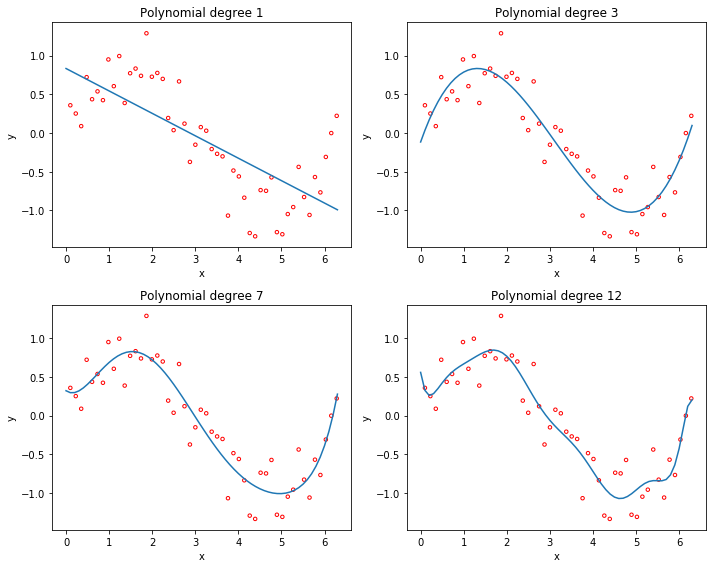

In [17]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [18]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    
    splits = [int(len(y)*ratio)]    #.cum() if severals
    x_train, x_test = np.split(x[indices], splits)
    y_train, y_test = np.split(y[indices], splits)
    # ***************************************************
    
    return x_train, y_train, x_test, y_test

Then, test your `split_data` function below.

In [20]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    # ***************************************************
    
    # ***************************************************
    x_train_expand = build_poly(x_train, degree)
    x_test_expand = build_poly(x_test, degree)
    # ***************************************************

    # ***************************************************
    w, mse_tr = least_squares(y_train, x_train_expand)
    mse_te = compute_mse(y_test, x_test_expand, w)
    # ***************************************************
    
    # ***************************************************
    rmse_tr = np.sqrt(2*mse_tr)
    rmse_te = np.sqrt(2*mse_te)
    # ***************************************************

    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [22]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.548
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.254
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=4.651


# 3 Ridge Regression
Please fill in the function below.

In [12]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # ***************************************************
    # lambda_prime = 2*N*lambda_
    w = np.linalg.solve(tx.T.dot(tx) + lambda_*2*len(y), tx.T.dot(y))
    # ***************************************************
    return w

In [45]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    x_train, y_train, x_test, y_test =  split_data(x, y, ratio, seed)
    # ***************************************************
    x_train_expand = build_poly(x_train, degree)
    x_test_expand = build_poly(x_test, degree)
    # ***************************************************

    # ***************************************************
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        wstar = ridge_regression(y_train, x_train_expand, lambda_)
        
        mse_tr = compute_mse(y_train, x_train_expand, wstar)
        mse_te = compute_mse(y_test, x_test_expand, wstar)
        
        rmse_tr.append(np.sqrt(2*mse_tr))
        rmse_te.append(np.sqrt(2*mse_te))
        # ***************************************************
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.339
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.340
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.346
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.372
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.459
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.235, Testing RMSE=0.646
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.244, Testing RMSE=0.893
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.253, Testing RMSE=1.113
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.261, Testing RMSE=1.256
proportion=0.5, degree=7, lambda=0.193, 

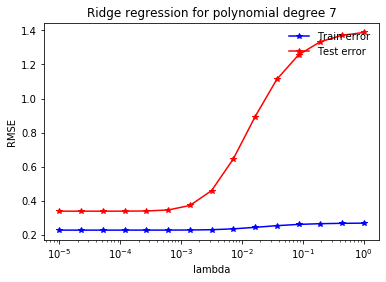

In [46]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)